In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from itertools import combinations

# NOTES
- Point of this notebook is to quantify performance of MTL model
- Establish a baseline
    - Look at SAME model (encoder + decoder) on each task individually
        - Probably heavily overfitting smaller cases
    - Mean of final performance + best performance
- Check if we beat the baseline 
    - Fit SAME model on tasks pairwise
    - Count how many times we see each task & how many times performance beats baseline
        - Again mean of final performance + best performance
    - Look at summary count as metric for model


# Baseline - singles

In [2]:
"""
cases = ['SZ',
        'ASD',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']
"""

bigs = ['SZ',
        #'ASD',
        'BIP'
        ]

smalls = ['DEL22q11_2',
        'DUP22q11_2',
        #'DEL16p11_2',
        #'DUP16p11_2',
        #'DEL1q21_1',
        #'DUP1q21_1'
        ]

cases = bigs + smalls

In [3]:
logs = os.listdir('logs')
single_results = []
for case in cases:
    for l in logs:
        seen = l.split('.')[0].split('-')[2:]
        if (case in seen) & (len(seen)==1):
            single_results.append(pd.read_csv(os.path.join('logs',l),header=[0,1],index_col=0))

In [4]:
# Call baseline avg of best & final accuracy
baseline = 0.5*(pd.concat(single_results,axis=1).iloc[-1] + pd.concat(single_results,axis=1).max()).loc[:,'Accuracy/test']

In [5]:
baseline

SZ            76.106195
BIP           61.764706
DEL22q11_2    86.111111
DUP22q11_2    94.444444
dtype: float64

## Plot training

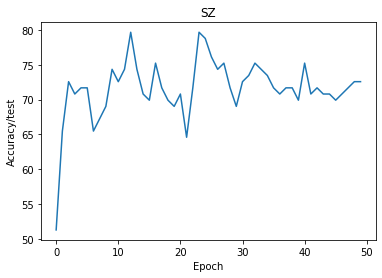

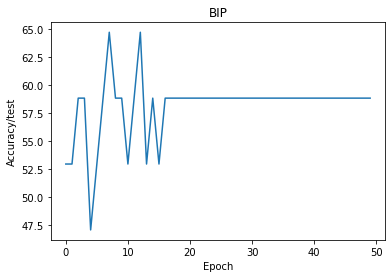

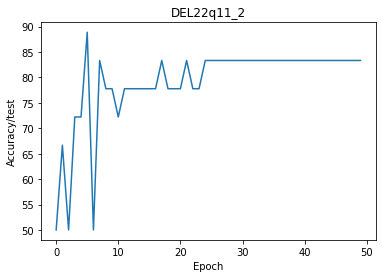

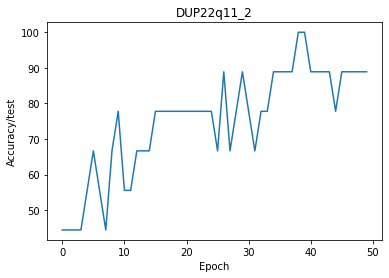

In [19]:
for case,df in zip(cases,single_results):
    sns.lineplot(x=df.index,y=df[case]['Accuracy/test'])
    plt.title(case)
    plt.xlabel('Epoch')
    plt.show()

# MTL - doubles

In [13]:
logs = os.listdir('logs')
prefix = '2022:03:23'
logs_filt = [l for l in logs if l[:len(prefix)]==prefix]

In [14]:
logs_filt

[]

In [6]:
pairs = []
pair_results = []
for case1,case2 in combinations(cases,2):
    for l in os.listdir('logs'):
        seen = l.split('.')[0].split('-')[2:]
        if (case1 in seen) and (case2 in seen):
            pairs.append((case1,case2))
            pair_results.append(pd.read_csv(os.path.join('logs',l),header=[0,1],index_col=0))

In [7]:
name_to_idx = dict(zip(cases,list(range(len(cases)))))
counts = np.zeros((len(cases),2))
vals = np.zeros((len(cases),len(cases)))

for pair, results in zip(pairs,pair_results):
    case1 = pair[0]
    case2 = pair[1]

    # Increment seen
    counts[name_to_idx[case1],1] += 1
    counts[name_to_idx[case2],1] += 1

    # Record vals
    case1_val = (results.max().loc[case1].loc['Accuracy/test'] + results.iloc[-1].loc[case1].loc['Accuracy/test'])/2
    case2_val = (results.max().loc[case2].loc['Accuracy/test'] + results.iloc[-1].loc[case2].loc['Accuracy/test'])/2

    vals[name_to_idx[case1],name_to_idx[case2]] = case1_val
    vals[name_to_idx[case2],name_to_idx[case1]] = case2_val

    # Increment beat
    if case1_val > baseline.loc[case1]:
        counts[name_to_idx[case1],0] += 1
    if case2_val > baseline.loc[case2]:
        counts[name_to_idx[case2],0] += 1
        
summary = pd.DataFrame(counts,index=cases,columns=['n_beat','n_seen'])
summary

,n_beat,n_seen
SZ,0.0,2.0
BIP,0.0,2.0
DEL22q11_2,1.0,2.0
DUP22q11_2,0.0,2.0


In [18]:
summary.append(summary.sum().rename('Total'))

,n_beat,n_seen
SZ,0.0,2.0
BIP,0.0,2.0
DEL22q11_2,1.0,2.0
DUP22q11_2,0.0,2.0
Total,1.0,8.0


## Plot training

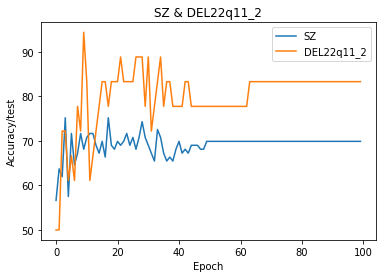

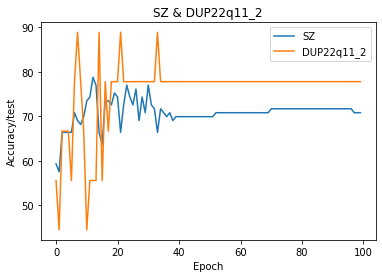

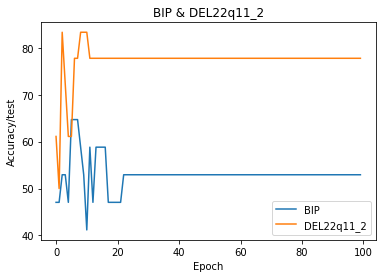

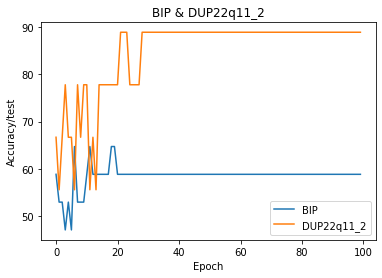

In [8]:
for pair,df in zip(pairs,pair_results):
    sns.lineplot(x=df.index,y=df[pair[0]]['Accuracy/test'],label=pair[0])
    sns.lineplot(x=df.index,y=df[pair[1]]['Accuracy/test'],label=pair[1])

    plt.title(f"{pair[0]} & {pair[1]}")
    plt.xlabel('Epoch')
    plt.show()